# Option Pricing and Stochastic Volatility using Neural Network

Understanding the deep-rooted uncertainty in the market volatility is essential for derivatives pricing and risk management. This study will aim introduce the data-driven concept through neural networks to price an option whose volatility is measured as a stochastic process.

In [2]:
import random
import warnings

random.seed(1926159)
warnings.filterwarnings("ignore")

## Simulated Training Data Collection

The simulated data is collected through a method called Euler's discretisation. Euler's discretisation is a simple and intuitive way to approximate the continuous-time dynamics of a stochastic process by breaking it down into discrete time steps.

In [3]:
import numpy as np

m, n, T = 1000, 252, 1

def eulers_discretion_simulation(s0: float, v0: float, kappa: float, theta: float, sigma: float, t: float, m: int, n: int, r: float) -> tuple:
    """
    Inputs:
     - s0, v0: Initial parameters for asset and variance.
     - kappa: Rate of mean reversion in variance process.
     - theta: Long-term mean of variance process.
     - sigma: Vol of vol / volatility of variance process.
     - T: Time of simulation.
     - N: Number of time steps.
     - M: Number of scenarios / simulations.
     - R: Risk Free Rate
    Outputs:
     - S: Asset prices over time (array).
     - V: Variance over time (array).
    """

    dt = t / m
    S = np.zeros((m, n + 1))
    V = np.zeros((m, n + 1))
    np.random.seed(1926159)
    for i in range(m):
        S[i, 0] = s0
        V[i, 0] = v0
        for j in range(1, n + 1):
            Z1 = np.random.randn()
            Z2 = np.random.randn()

            dS = r * S[i, j - 1] * dt + np.sqrt(V[i, j - 1] * dt) * Z1
            dV = kappa * (theta - V[i, j - 1]) * dt + sigma * np.sqrt(V[i, j - 1] * dt) * Z2

            S[i, j] = S[i, j - 1] + dS
            V[i, j] = V[i, j - 1] + dV

    return S, V

S, V = eulers_discretion_simulation(100, 0.1, 2.0, 0.1, 0.2, 1, 1000, 252, 0.05)

## Data Pre-Processing

The Data is split into 80-20 train-validation ratio.

Scaling is applied as normalisation strategy to aid the neural network.

In [4]:
import numpy as np

def format_data(data: list, sequence_length: int) -> tuple:
    """
    Inputs:
    - data: Simulated Heston Data.
    - sequence_length: Considered Time Steps.
    Return:
    - Testing and Training Data.
    """
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(x), np.array(y)

In [5]:
sequence_length = 10

flat_S = S.flatten()
flat_S = (flat_S - np.mean(flat_S)) / np.std(flat_S)

split_ratio = 0.8
split_index = int(len(flat_S) * split_ratio)

train_data = flat_S[:split_index]
test_data = flat_S[split_index:]

x_train, y_train = format_data(train_data, sequence_length)
x_test, y_test = format_data(test_data, sequence_length)

## Neural Network Implementation

- Multilayer Perceptron’s (MLP) Feed Forward Network.
- Hidden fully connected layers, each with 100 neurons.
- Batch size of 64.
- 10 training epochs.
- 80-20 train-validation split.
- Mean Squared error as loss function.


In [6]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(
    hidden_layer_sizes=(100,100,100,100),
    solver='adam',
    shuffle = False,
    batch_size=64,
    verbose=True,
    max_iter= 25
)

## Hyperparameter Tuning

To select the optimal hyperparameters each proposed hyperparameter setting is evaluated against the model and the one that produces the best performance is chosen. In this study hyperparameter tuning will be performed though leveraging a Grid Search integrated with cross-validation.

In [7]:
from sklearn.model_selection import GridSearchCV

model.get_params()

parameter_space = {
    'activation': ['tanh', 'relu'],
    'alpha': [0.01, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=3)
clf.fit(x_train, y_train)

print('Best parameters found:\n', clf.best_params_)

/Users/harvey/Documents/Portfolio/Option Pricing and Stochastic Volatility/environment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/harvey/Documents/Portfolio/Option Pricing and Stochastic Volatility/environment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/harvey/Documents/Portfolio/Option Pricing and Stochastic Volatility/environment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/harvey/Documents/Portfolio/Option Pricing and Stochastic Volatility/environment/l

Iteration 1, loss = 0.03436561
Iteration 2, loss = 0.02577214
Iteration 3, loss = 0.02409512
Iteration 4, loss = 0.02358996
Iteration 5, loss = 0.02334735
Iteration 6, loss = 0.02319992
Iteration 7, loss = 0.02311617
Iteration 8, loss = 0.02304726
Iteration 9, loss = 0.02300418
Iteration 10, loss = 0.02296550
Iteration 11, loss = 0.02293039
Iteration 12, loss = 0.02290741
Iteration 13, loss = 0.02289680
Iteration 14, loss = 0.02287996
Iteration 15, loss = 0.02286594
Iteration 16, loss = 0.02285808
Iteration 17, loss = 0.02286069
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Best parameters found:
 {'activation': 'relu', 'alpha': 0.01, 'learning_rate': 'constant'}


### Sensitivity Analysis

In [8]:
import matplotlib.pyplot as plt

def sensitivity_analysis(model, x):
    """
    Inputs:
    - model: MLP model.
    - x: Test data.
    Return:
    - Sensitivity of feature.
    """
    baseline_prediction = model.predict(x)
    epsilon = 0.01
    x_perturbed = x.copy()
    x_perturbed[:, 0] += epsilon
    perturbed_prediction = model.predict(x_perturbed)
    sensitivity = perturbed_prediction - baseline_prediction
    return sensitivity

sensitivity = sensitivity_analysis(model, x_test)

plt.figure(figsize=(8, 6))
plt.scatter(x_test[:, 0], sensitivity, label='Sensitivity Analysis', c='r')
plt.xlabel(f'Feature')
plt.ylabel('Sensitivity')
plt.title('Sensitivity Analysis of Heston MLP Model')
plt.legend()
plt.grid(True)
plt.show()

Iteration 1, loss = 0.03400389
Iteration 2, loss = 0.02570297
Iteration 3, loss = 0.02412766
Iteration 4, loss = 0.02367747
Iteration 5, loss = 0.02348125
Iteration 6, loss = 0.02332374
Iteration 7, loss = 0.02323480
Iteration 8, loss = 0.02313389
Iteration 9, loss = 0.02307530
Iteration 10, loss = 0.02302162
Iteration 11, loss = 0.02298394
Iteration 12, loss = 0.02295341
Iteration 13, loss = 0.02293160
Iteration 14, loss = 0.02291122
Iteration 15, loss = 0.02290068
Iteration 16, loss = 0.02288502
Iteration 17, loss = 0.02286910
Iteration 18, loss = 0.02286048
Iteration 19, loss = 0.02284159
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPRegressor(alpha=0.01, batch_size=64, hidden_layer_sizes=(100, 100, 100, 100),
             max_iter=25, shuffle=False, verbose=True)

## Network Training

The process initiates with forward propagation, where input data undergoes a series of transformations.

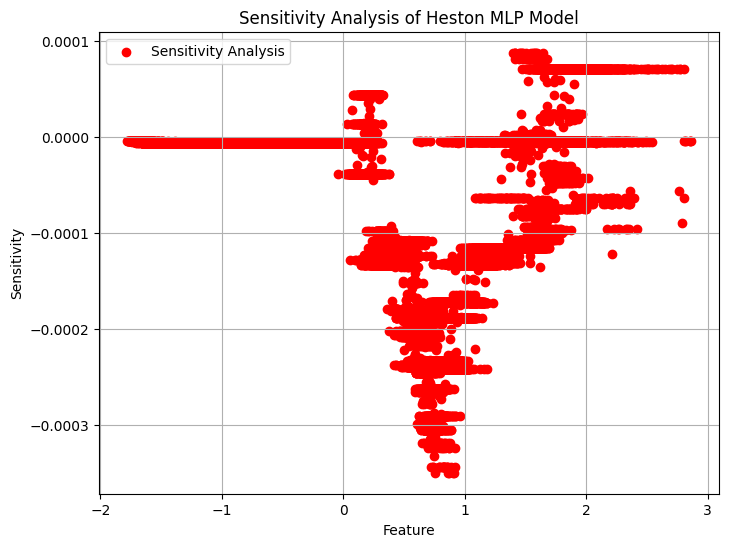

In [9]:
model.fit(x_train, y_train)

### Download & Upload Model

In [10]:
import pickle

filename = 'neural_network_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [11]:
filename = 'neural_network_model.sav'
model = pickle.load(open(filename, 'rb'))

## Monte Carlo Simulation

The Monte Carlo method is a computational technique used to solve complex mathematical problems by simulating random processes.

In [12]:
from heston_monte_carlo import heston_model_monte_carlo_simulation

S, V = heston_model_monte_carlo_simulation(100, 0.1, 0, 2.0, 0.1, 0.2, 1, 1000, 252)

sequence_length = 10

flat_S = S.flatten()
flat_S = (flat_S - np.mean(flat_S)) / np.std(flat_S)

split_ratio = 0.8
split_index = int(len(flat_S) * split_ratio)

train_data = flat_S[:split_index]
test_data = flat_S[split_index:]

x_predicted, monte_carlo_y_predicted = format_data(test_data, sequence_length)

## Testing And Analysis

### Error Analysis

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import pandas as pd

neural_network_y_predicted = model.predict(x_test)

def performance_analysis(true: list, predicted: list):
    """
    Inputs:
    - true: The real value.
    - predicted: The model predicted value.
    Return:
    - Results Data Frame.
    """
    mse = mean_squared_error(true, predicted)
    rmse = sqrt(mse)
    mae = mean_absolute_error(true, predicted)
    r2 = r2_score(true, predicted)
    df = {'Mean Squared Error': [mse], 'Root Mean Squared Error': [rmse], 'Mean Absolute Error': [mae], 'R2 Score': [r2]}
    return pd.DataFrame(data=df)

In [14]:
print("Monte Carlo Results:")
print(performance_analysis(y_test[0:50000], monte_carlo_y_predicted[0:50000]))
print("Neural Network Results:")
print(performance_analysis(y_test[0:50000], neural_network_y_predicted[0:50000]))

Monte Carlo Results:
   Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  R2 Score
0            1.176549                 1.084689             0.904559  -0.18312
Neural Network Results:
   Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  R2 Score
0            0.043773                 0.209221             0.044702  0.955982


### Option Pricing

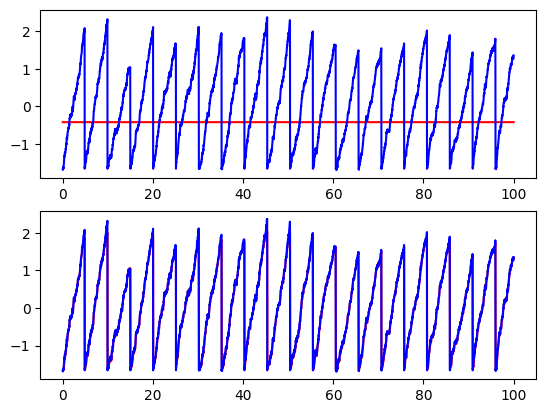

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1)

x = np.linspace(0, 100, 5000)
ax[0].plot(x, monte_carlo_y_predicted[0:5000], label='Monte Carlo Prediction', c='r')
ax[0].plot(x, y_test[0:5000], label='Actual Price', c='b')

x = np.linspace(0, 100, 5000)
ax[1].plot(x, neural_network_y_predicted[0:5000], label='Neural Network Prediction', c='r')
ax[1].plot(x, y_test[0:5000], label='Actual Price', c='b')